# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [83]:
# Basic pandas and numpy
import pandas as pd
import numpy as np
 
# Basic visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# Winsorizer for outlier management
from scipy.stats.mstats import winsorize
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [84]:
customers = pd.read_csv('../data/Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [85]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [86]:
customers.shape

(440, 8)

In [87]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [88]:
customers.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [89]:
customers.Channel.value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [90]:
customers.Region.value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [91]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [92]:
quant = [col for col in customers.columns if col != 'Channel' and col != 'Region']

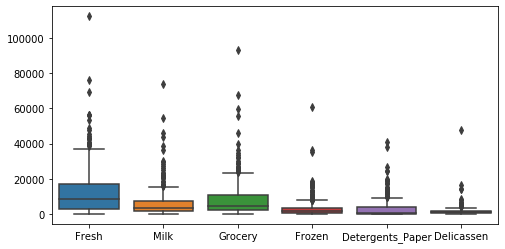

In [93]:
plt.figure(figsize=(8,4))
sns.boxplot(data=customers[quant])

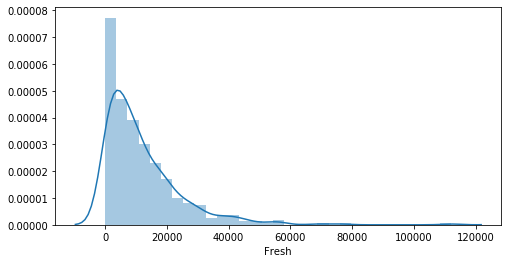

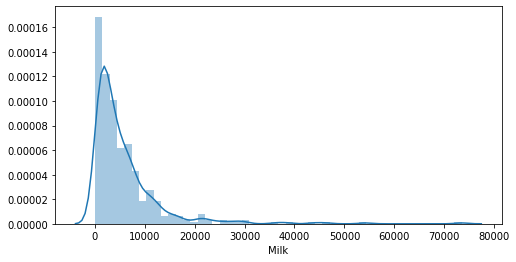

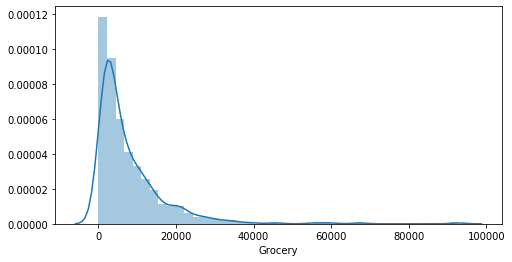

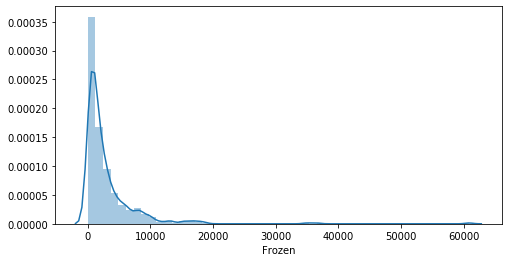

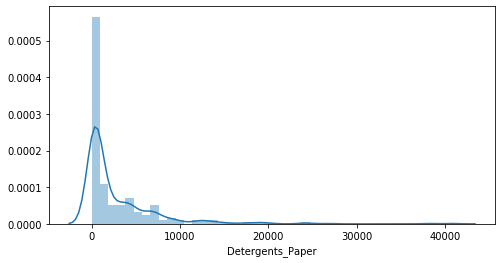

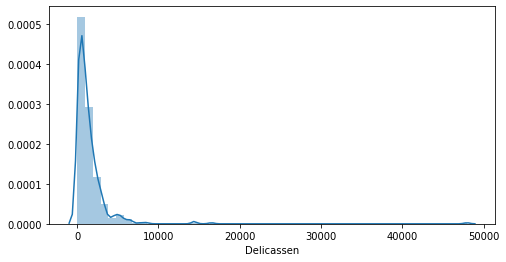

In [94]:
for i in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    plt.figure(figsize=(8,4))
    sns.distplot(customers[i])

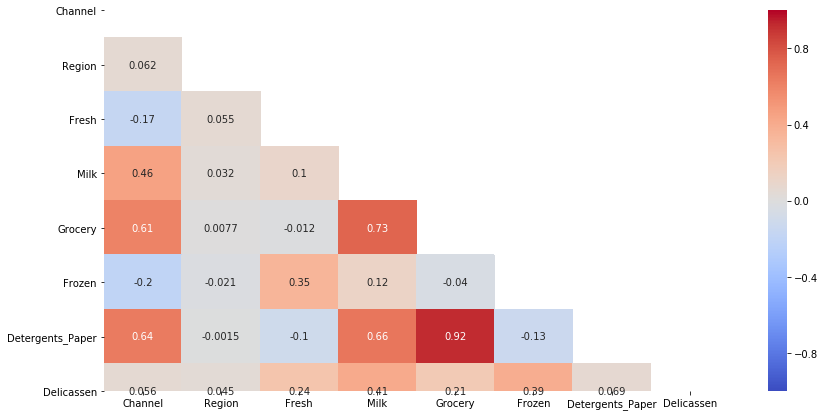

In [95]:
# Set Variables:
cormat = customers.corr()
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

* No categorical data to convert. Although Channel and Region seem to be nominal variables, they are correctly codified as integer.
* There is no null data in the dataset.
* All the numerical variables are skewed to the left with many high outliers. 
* Detergents_Paper and Grocery are strongly positively correlated (0.92)

* **Numerical variables:** 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'. It seems to be a continuous variable, although it is codified as integer.
* **Categorical variables:** 'Channel', 'Region', both nominal.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

I believe two things can be done. First off, we can get rid of either 'Detergents_Paper' or 'Grocery' as they correlate strongly. Second, we will manage the outliers:

In [96]:
# Dropping one of the correlated columns:
customers.drop('Detergents_Paper', inplace=True, axis=1)

In [97]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [112]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,1338,0,0
1,2,3,7057,9810,9568,1762,1776,0,0
2,2,3,6353,8808,7684,2405,7844,0,-1
3,1,3,13265,1196,4221,6404,1788,2,0
4,2,3,22615,5410,7198,3915,5185,6,-1


In [113]:
quant

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [98]:
# Your import here:
from sklearn.preprocessing import StandardScaler

# Your code here:
data = customers[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Delicassen']]
scaler = StandardScaler()
scaler.fit(data)
customers_scale = scaler.transform(data)

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [99]:
from sklearn.cluster import KMeans

kmeans = KMeans()
clusters = kmeans.fit(customers_scale)

In [100]:
customers['labels'] = clusters.labels_

Count the values in `labels`.

In [101]:
customers.labels.value_counts()

2    189
6    100
0     95
7     34
4     14
3      5
5      2
1      1
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [102]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5).fit(customers_scale)
customers['labels_DBSCAN'] = dbscan.labels_

Count the values in `labels_DBSCAN`.

In [103]:
customers.labels_DBSCAN.value_counts()

 0    294
-1    133
 1      7
 2      6
Name: labels_DBSCAN, dtype: int64

In [104]:
# Many observations in the 'Noise' group

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

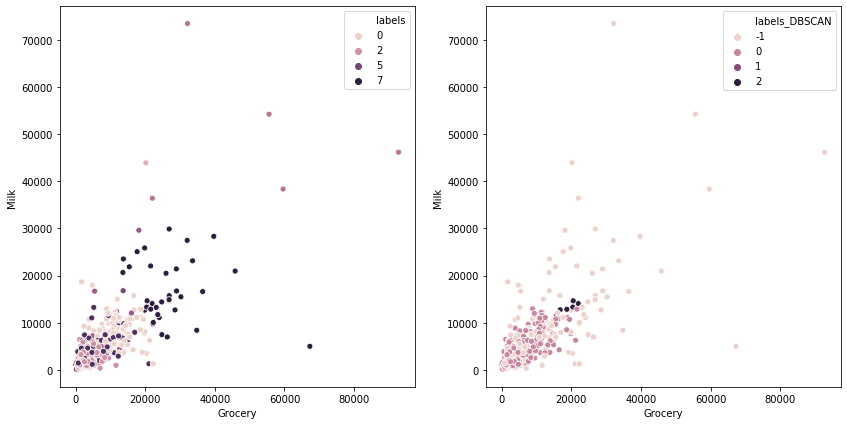

In [105]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plt.sca(ax1)
ax1 = sns.scatterplot(x=customers.Grocery, y=customers.Milk, hue=customers.labels)
plt.sca(ax2)
ax2 = sns.scatterplot(x=customers.Grocery, y=customers.Milk, hue=customers.labels_DBSCAN)

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

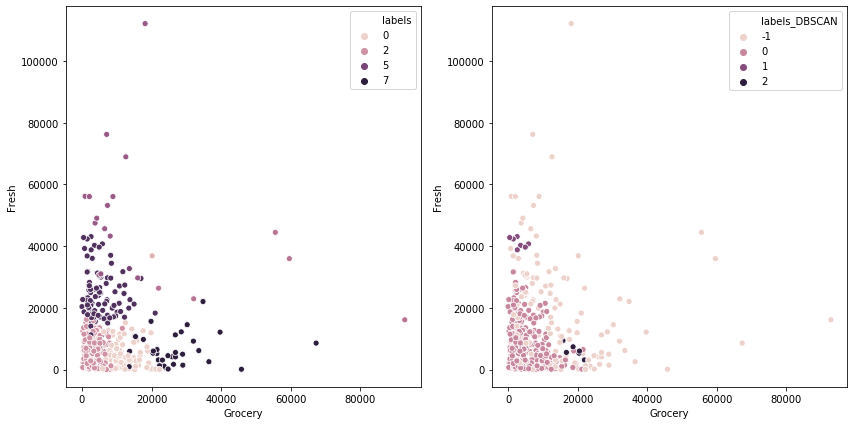

In [106]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
plt.sca(ax1)
ax1 = sns.scatterplot(x= customers.Grocery, y= customers.Fresh, hue= customers.labels)
plt.sca(ax2)
ax2 = sns.scatterplot(x= customers.Grocery, y= customers.Fresh, hue= customers.labels_DBSCAN)

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

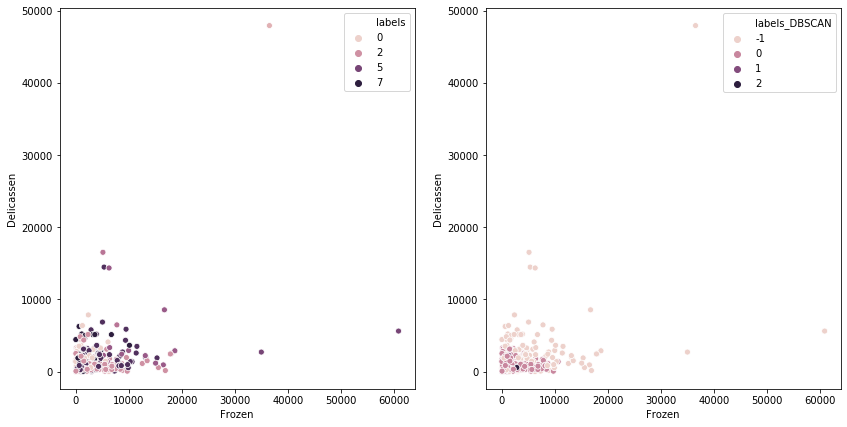

In [107]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
plt.sca(ax1)
ax1 = sns.scatterplot(x=customers.Frozen, y=customers.Delicassen, hue=customers.labels)
plt.sca(ax2)
ax2 = sns.scatterplot(x=customers.Frozen, y=customers.Delicassen, hue=customers.labels_DBSCAN)

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [110]:
customers.groupby(['labels'], as_index=False).mean()

,labels,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,labels_DBSCAN
0,0,1.736842,2.631579,4646.957895,8162.326316,11551.852632,1239.452632,1467.600000,-0.210526
1,1,1.000000,3.000000,36847.000000,43950.000000,20170.000000,36534.000000,47943.000000,-1.000000
2,2,1.063492,2.502646,6841.052910,2173.148148,3043.037037,2561.126984,802.798942,-0.074074
3,3,2.000000,3.000000,29164.600000,49749.200000,52416.400000,3640.600000,5770.400000,-1.000000
4,4,1.000000,2.428571,53976.285714,7539.571429,7583.142857,10804.285714,3279.142857,-1.000000
5,5,1.000000,2.500000,22015.500000,9937.000000,7844.000000,47939.000000,4153.500000,-1.000000
6,6,1.230000,2.600000,23625.760000,3776.860000,5120.030000,3759.320000,1760.290000,-0.340000
7,7,1.941176,2.323529,5904.882353,16717.676471,26761.617647,2118.882353,2139.794118,-0.705882


In [111]:
customers.groupby(['labels_DBSCAN'], as_index=False).mean()

,labels_DBSCAN,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,labels
0,-1,1.481203,2.56391,18130.578947,10810.631579,14247.255639,5725.669173,2885.654135,4.255639
1,0,1.238095,2.52381,8654.612245,3463.867347,4992.884354,1937.965986,935.374150,2.275510
2,1,1.285714,3.00000,41090.428571,2138.000000,3095.571429,1182.571429,1062.428571,6.000000
3,2,2.000000,2.50000,6112.500000,13200.000000,19016.666667,2016.000000,785.666667,3.500000


Which algorithm appears to perform better?

K-Means seems to perform better. DBSCAN results in a lot of noise.

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here